## Lab 4 - part 2: Data Weights and Autocorellation

**TU Delft and WUR**<br>
**Q1 2024**<br>
**Instructor:** Theodoros Chatzivasileiadis <br>
**Instructor:** Hans Hoogenboom <br>
**TA:** Ka Yi Chua <br>
**[Metropolitan Data 1](https://jhoogenboom.github.io/spatial-data-science/_index.html)** <br>



## Exercise 4a: Spatial Autocorrelation and ESDA 

USE the Liverpool IMD data we have been using in previous sessions. This will require you to:

* Load up the IMD dataset for Liverpool.
* Create a choropleth of the `imd_score` variable.
* Compute the spatial weights matrix for the LSOAs. Think of one criterium to build it that you think would fit this variable (e.g. contiguity, distance-based, etc.), and apply it.
* Create the standardized version of the IMD scores.
* Calculate the spatial lag of the standardized scores.
* Create the Moran Plot.
* Calculate the value of Moran's I as well as its significance level.
* Perform a LISA analysis and generate a map of the results. What are the main patterns?

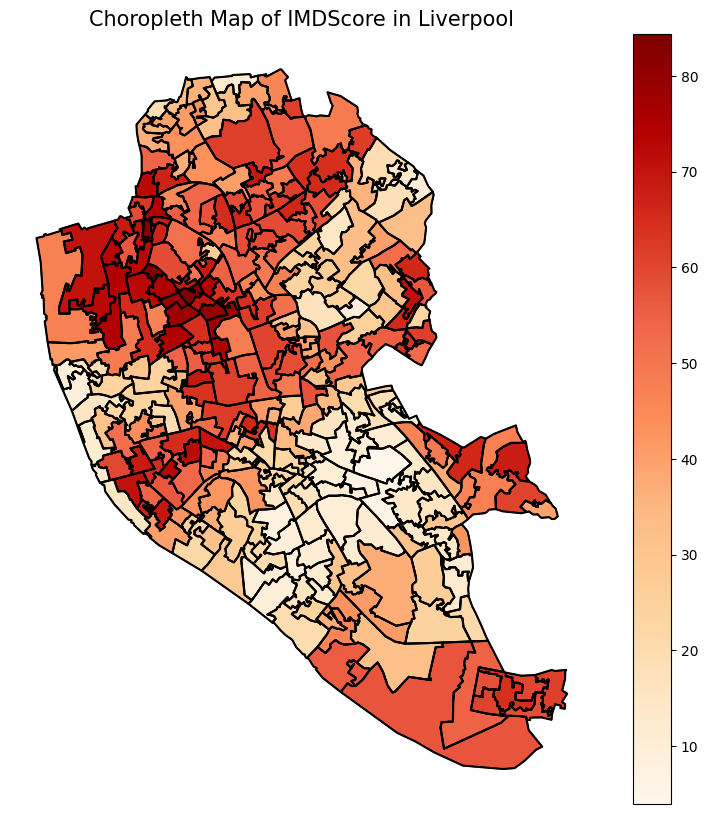

In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from libpysal import weights
from libpysal.weights import Queen

# step 1
imdL = "C:/Users/joche/Documents/MADE/Period 1/Data 1/lab-03/data/IMD/IMD" # import the file.
imdL= gpd.read_file(imdL) # the next lines read and show the data.
# imdL.info()
# print(imdL.head())  # Check the first few rows to find any columns related to location

liverpool_data = imdL[imdL['LADnm'] == 'Liverpool']  # Zooming in on Liverpool

# Choose the column to visualize
variable_to_map = 'IMDScore'  # Replace with the actual column name for the variable

# Create the chloropleth map zoomed to Liverpool
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
liverpool_data.boundary.plot(ax=ax, color='k')  # Add boundaries for reference
liverpool_data.plot(column=variable_to_map, ax=ax, legend=True,
                    cmap='OrRd',  # Choose a colormap
                    edgecolor='black')  # Outline color for the regions

# Add title and labels
ax.set_title(f'Choropleth Map of {variable_to_map} in Liverpool', fontsize=15)
ax.set_axis_off()  # Turn off the axis

# Show the plot
plt.show()

In [2]:
import geopandas as gpd
from libpysal.weights import Queen, Rook, DistanceBand

# step 2
# Load the LSOA shapefile
lsoa_shp = "C:/Users/joche/Documents/MADE/Period 1/Data 1/lab-03/data/IMD/IMD/lab04_imd.shp"
lsoa_gdf = gpd.read_file(lsoa_shp)
# print(lsoa_gdf.head())

# Project the data to an appropriate CRS (e.g., EPSG 27700 for British National Grid)
lsoa_gdf = lsoa_gdf.to_crs(epsg=27700)

# As we have shapes, we need a centerpoint. Therefore the next step is taken.
lsoa_gdf['center'] = lsoa_gdf.geometry.centroid 
    
# Create a copy of the original GeoDataFrame to store the centroid points set.
center_gdf = lsoa_gdf.copy()
    
# Set the geometry of the new GeoDataFrame to contain only the centroid coordinates as calculated before.
center_gdf.set_geometry('center', inplace=True)
    
# Create the spatial weight matrix using the distance-based approach.
w_distance = DistanceBand.from_dataframe(center_gdf, threshold=500, ids='lsoa11cd')
print(w_distance['E01000003'])


c:\Users\joche\AppData\Local\Programs\Python\Python312\Lib\site-packages\libpysal\weights\util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 22060 disconnected components.
 There are 18935 islands with ids: E01000023, E01000027, E01000028, E01000031, E01000032, E01000034, E01000035, E01000039, E01000072, E01000075, E01000087, E01000090, E01000092, E01000094, E01000095, E01000096, E01000103, E01000107, E01000109, E01000114, E01000136, E01000150, E01000164, E01000166, E01000167, E01000168, E01000184, E01000188, E01000194, E01000195, E01000201, E01000205, E01000206, E01000212, E01000214, E01000221, E01000228, E01000232, E01000240, E01000248, E01000249, E01000250, E01000253, E01000254, E01000255, E01000256, E01000257, E01000258, E01000259, E01000260, E01000261, E01000262, E01000266, E01000276, E01000278, E01000279, E01000280, E01000282, E01000286, E01000290, E01000291, E01000305, E01000308, E01000309, E01000315, E01000325, E01000328, E01000329, E01000331, E010

{'E01000001': 1.0, 'E01000002': 1.0, 'E01002706': 1.0, 'E01033489': 1.0, 'E01033490': 1.0}


In [3]:
import numpy as np

# step 3
imd_column = 'IMDScore'  

# Calculate the mean and standard deviation of the IMD scores
mean_imd = lsoa_gdf[imd_column].mean()
std_imd = lsoa_gdf[imd_column].std()

# Calculate the standardized IMD scores 
lsoa_gdf['IMD_standardized'] = (lsoa_gdf[imd_column] - mean_imd) / std_imd

# The updated GeoDataFrame with the new standardized scores
print(lsoa_gdf[['lsoa11cd', imd_column, 'IMD_standardized']].head())

    lsoa11cd  IMDScore  IMD_standardized
0  E01000001     6.208         -1.008424
1  E01000002     5.143         -1.077886
2  E01000003    19.402         -0.147884
3  E01000005    28.652          0.455420
4  E01000006    19.837         -0.119512


In [5]:
from libpysal.weights import DistanceBand, lag_spatial
# step 4
imd_column = 'IMDScore' 

# Calculate the spatial lag for the IMD scores
lsoa_gdf['IMD_spatial_lag'] = lag_spatial(w_distance, lsoa_gdf[imd_column])

# Preview the GeoDataFrame with the new spatial lag column
print(lsoa_gdf[['lsoa11cd', imd_column, 'IMD_spatial_lag']].head())

    lsoa11cd  IMDScore  IMD_spatial_lag
0  E01000001     6.208           24.545
1  E01000002     5.143           25.610
2  E01000003    19.402           68.307
3  E01000005    28.652           49.126
4  E01000006    19.837           86.836


# Here we stopped with this exercise since it was not mandatory to do this one. However, it was helpful for the other exercises!

For this part I would like you to experiment with Data from Amsterdam. However this will require you to find the dataset yourself!

## Question 1: Building a Contiguity-Based Weight Matrix

Use PySAL to create a contiguity-based weight matrix (W) for a given spatial dataset of polygons. Write a function create_contiguity_weights that:

    Reads in a shapefile of polygons.
    Constructs a Queen contiguity-based spatial weights matrix.
    Returns the weight matrix.

## Question 2: Calculating Moran’s I

Write a function calculate_morans_i that:

    Takes a spatial weight matrix W and an attribute array y.
    Calculates Moran’s I for the given attribute array.
    Returns the Moran’s I value and its p-value.

## Question 3: Standardizing Spatial Weight Matrices

Create a function standardize_weights that:

    Takes a spatial weight matrix W.
    Standardizes it so that the weights of each row sum to one.
    Returns the standardized weight matrix.

## Question 4: Creating Distance-Based Weights

Write a function create_distance_weights that:

    Takes a set of point coordinates and a threshold distance.
    Constructs a distance-based spatial weight matrix where all points within the threshold distance are assigned a weight.
    Returns the weight matrix.

## Question 5: Visualizing a Moran Plot

Using PySAL, write a function plot_moran that:

    Takes a spatial weights matrix W and an attribute array y.
    Creates and displays a Moran plot for the attribute.
    Saves the Moran plot as an image file.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Adres         506 non-null    object  
 1   Soort         506 non-null    object  
 2   Datum         506 non-null    object  
 3   Omschrijving  506 non-null    object  
 4   Foto          506 non-null    object  
 5   geometry      506 non-null    geometry
dtypes: geometry(1), object(5)
memory usage: 23.8+ KB


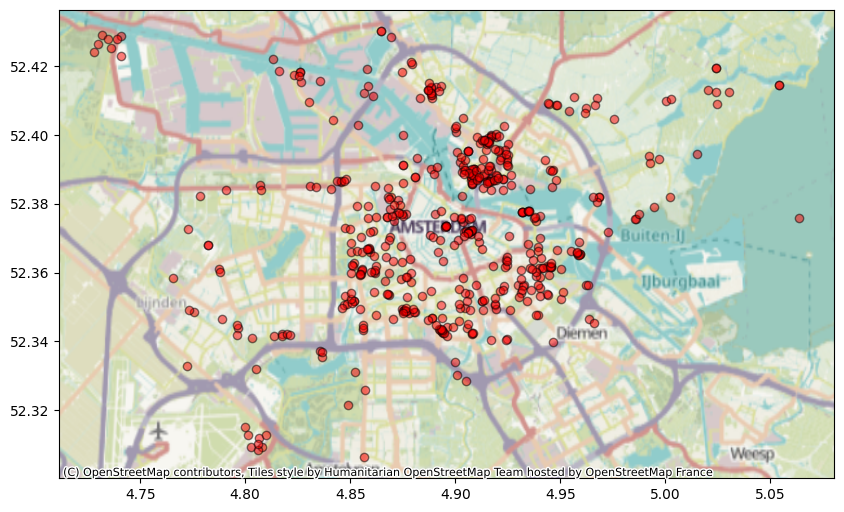

In [1]:
import seaborn as sns
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

# Exercise 0

# First we decided to use this shapefile. Made with point data. This shapefile shows data from Amsterdam during world war 2. We have downloaded the geojson LngLat data
# and copied it into a shapefile using VSC. It is really interesting to see the point data as you can recognize Amsterdam and specific places that were not bombed.
# Examples of these places not boing bombed are the Grachtengordel. 

imd_shp1 = 'C:/Users/joche/Documents/MADE/Period 1/Data 1/lab-03/data/Amsterdam' # import the shapefile.
imd1 = gpd.read_file(imd_shp1) # the next lines read and show the data.
imd1.info()

fig, ax = plt.subplots(figsize=(10, 10))
imd1.plot(ax=ax, color='red', alpha=0.5, edgecolor='black')

# Then we added a basemap
ctx.add_basemap(ax, crs=imd1.crs.to_string())

# And finally, show it.
plt.show()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   CBS_Buurtcode   518 non-null    object  
 1   Buurtcode       518 non-null    object  
 2   Buurt           518 non-null    object  
 3   Wijkcode        518 non-null    object  
 4   Wijk            518 non-null    object  
 5   Gebiedcode      518 non-null    object  
 6   Gebied          518 non-null    object  
 7   Stadsdeelcode   518 non-null    object  
 8   Stadsdeel       518 non-null    object  
 9   Oppervlakte_m2  518 non-null    int64   
 10  geometry        518 non-null    geometry
dtypes: geometry(1), int64(1), object(9)
memory usage: 44.6+ KB


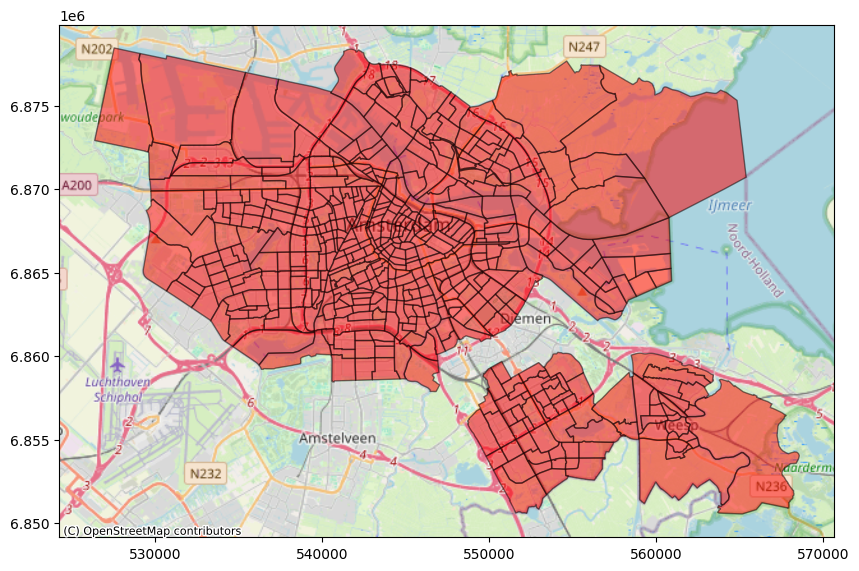

In [2]:
# Exercise 0.1
# However, for this exercise, we needed a shapefile with polygons. We have downloaded the geojson LngLat data
# and copied it into a shapefile using VSC. So, we decided to use districts (wijken) in Amsterdam.

 # import the shapefile.
imd_shp = 'C:/Users/joche/Documents/MADE/Period 1/Data 1/lab-03/data/Amsterdam-neighbourhoods'
imd = gpd.read_file(imd_shp) 

# the next lines read and show the data.
imd.info()

# Set the coordination system and figsize including decoration such as colors.
fig, ax = plt.subplots(figsize=(10, 10))
imd = imd.to_crs(epsg=3857)
imd.plot(ax=ax, color='red', alpha=0.5, edgecolor='black')

# Check if CRS is set, if not, set it. We use WGS84 or EPSG: 4326
if imd.crs is None:
    imd.set_crs(epsg=4326, inplace=True) 

# Reproject to web Mercator (EPSG:3857)
imd = imd.to_crs(epsg=3857)

# Then we added the basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# show it:
plt.show()



In [3]:
#importing everything else that is important
import numpy as np
from libpysal import weights
from libpysal.weights import Queen
import libpysal
import matplotlib.pyplot as plt
import contextily as ctx
from pysal.explore import esda
import pandas as pd
import geopandas as gpd
from esda.moran import Moran
from libpysal.weights import DistanceBand 
from libpysal.weights import lag_spatial

c:\Users\joche\AppData\Local\Programs\Python\Python312\Lib\site-packages\spaghetti\network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)
c:\Users\joche\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# Exercise 1

# We wanted to see the first table lines and decided we used the "CBS_Buurtcode".
imd.head() 

# First, we define a function named create_conguite_weights. It relies on imd_shp. Then, we read the shapefile into a GDF called imd. After that, we use weights.Queen.from_dataframe() to generate a weight matrix. returning and printing shows that it works.
def create_conguite_weights():
    imd = gpd.read_file(imd_shp) 
    w_queen = weights.Queen.from_dataframe(imd, ids="CBS_Buurtcode")
    return w_queen
print(create_conguite_weights())

# Now, we want to test what it shows, we used the row with number 1 to test.
w_queen = weights.Queen.from_dataframe(imd, ids="CBS_Buurtcode")
w_queen['BU0363AC03'] 

c:\Users\joche\AppData\Local\Programs\Python\Python312\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


{'BU0363AD04': 1.0,
 'BU0363AD06': 1.0,
 'BU0363AB10': 1.0,
 'BU0363AB07': 1.0,
 'BU0363AC02': 1.0,
 'BU0363AC04': 1.0}

In [10]:
# Exercise 2

# Extract the variable of interest
y = imd['Oppervlakte_m2'].values

# Recreate a spatial weights object from the imd shapefile using Queen contiguity, based on last exercise. Added index=False to prevent warning.
W = Queen.from_dataframe(imd, use_index=False)

# Function to calculate Moran's I. 
def calculate_morans_i(W, y):
    y = np.array(y)
    moran = Moran(y, W)
    return moran.I, moran.p_sim

# Calculate Moran's I and p-value
morans_i, p_value = calculate_morans_i(W, y)

# Print the results
print(f"Moran's I: {morans_i}")
print(f"p-value: {p_value}")

# comments and notes:

# W: Spatial weights matrix (defines neighborhood relationships).
# y: Values of the variable of interest.

# Steps:
# Convert y to a NumPy array.
# Create a Moran object with y and W to compute Moran's I.
# Return:
# moran.I: Value of Moran's I (indicates clustering of similar or dissimilar values).
# moran.p_sim: p-value for statistical significance.

Moran's I: 0.3394780199685298
p-value: 0.001


In [11]:
# Exercise 3

def standardize_weights(W):
   
    # Create a dense matrix from the spatial weights object.
    weight_matrix = W.full()[0]  
    
    # Calculate row sums.
    row_sums = weight_matrix.sum(axis=1)
    
    # This will handle zero sums. Any zero will be replaced with 1.
    row_sums[row_sums == 0] = 1  # Prevent division by zero
    
    # Standardize weights: divide each row by its sum
    standardized_matrix = weight_matrix / row_sums[:, np.newaxis]  # Broadcasting (The term broadcasting describes how NumPy treats arrays with different shapes during arithmetic operations -Numpy.org) to standardize
    
    return standardized_matrix

# Standardize the weights
standardized_W = standardize_weights(w_queen)

# Output of the standardized weights
print("Standardized Weight Matrix:")
print(standardized_W)


Standardized Weight Matrix:
[[0.         0.14285714 0.         ... 0.14285714 0.         0.14285714]
 [0.16666667 0.         0.16666667 ... 0.16666667 0.         0.        ]
 [0.         0.16666667 0.         ... 0.16666667 0.16666667 0.        ]
 ...
 [0.125      0.125      0.125      ... 0.         0.125      0.        ]
 [0.         0.         0.2        ... 0.2        0.         0.        ]
 [0.14285714 0.         0.         ... 0.         0.         0.        ]]


In [7]:
# Exercise 4

def create_distance_based_weights(imd, threshold=500, id_column='CBS_Buurtcode'):
       
    # Set to projected coordinate system (EPSG:28992).
    imd = imd.to_crs(epsg=28992)
    
    # As we have shapes, we need a centerpoint. Therefore the next step is taken.
    imd['center'] = imd.geometry.centroid 
    
    # Create a copy of the original GeoDataFrame to store the centroid points set.
    center_imd = imd.copy()
    
    # Set the geometry of the new GeoDataFrame to contain only the centroid coordinates as calculated before.
    center_imd.set_geometry('center', inplace=True)
    
    # Create the spatial weight matrix using the distance-based approach.
    w_distance = DistanceBand.from_dataframe(center_imd, threshold=threshold, ids=id_column)
    
    return w_distance

# Example how to use. Distance from centerpoint is set as 500 meters.
w_distance = create_distance_based_weights(imd, threshold=500, id_column='CBS_Buurtcode')

# Example to show the weights for neighbourhood BU0363AD06.
print(w_distance['BU0363AD06'])

{'BU0363AC03': 1.0, 'BU0363AC04': 1.0, 'BU0363AD04': 1.0, 'BU0363AD05': 1.0, 'BU0363AD07': 1.0, 'BU0363AD08': 1.0, 'BU0363AE04': 1.0, 'BU0363AE05': 1.0}


c:\Users\joche\AppData\Local\Programs\Python\Python312\Lib\site-packages\libpysal\weights\util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 145 disconnected components.
 There are 113 islands with ids: BU0363MK02, BU0363MK06, BU0363MK03, BU0363MA01, BU0363MA02, BU0363MG04, BU0363MK04, BU0363MH01, BU0363MH02, BU0363MH03, BU0363MH05, BU0363MH06, BU0363MK05, BU0363MJ01, BU0363MJ02, BU0363MJ03, BU0363MJ04, BU0363MJ05, BU0363MK01, BU0363MN04, BU0363MN05, BU0363MP02, BU0363MP03, BU0363MQ02, BU0363NA01, BU0363NA02, BU0363NB01, BU0363NB02, BU0363NB03, BU0363NB04, BU0363NB07, BU0363ND01, BU0363ND02, BU0363NG01, BU0363NJ01, BU0363NL04, BU0363NP01, BU0363NP03, BU0363NQ01, BU0363NQ03, BU0363NQ04, BU0363NQ05, BU0363NQ06, BU0363NQ07, BU0363NQ08, BU0363NQ09, BU0363NQ10, BU0363SA01, BU0363SA02, BU0363SB01, BU0363SB02, BU0363SB03, BU0363SB04, BU0363SB06, BU0363SE01, BU0363SE04, BU0363BA01, BU0363BA02, BU0363BA03, BU0363BA04, BU0363BA05, BU0363BB01, BU0363BB02, BU0363FA06,

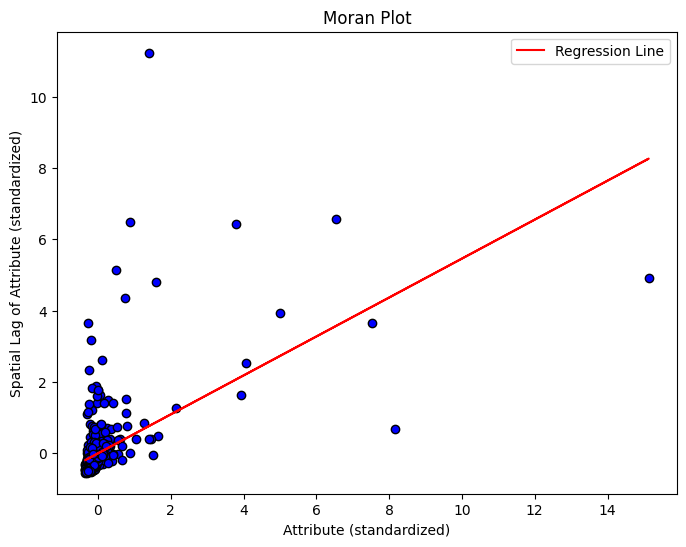

In [8]:
# Exercise 5

# y = imd['Oppervlakte_m2'].values and W = Queen.from_dataframe(imd, use_index=False) are used from previous exercise.

# Function to plot Moran's plot
def plot_moran(W, y, output_image_path):
    # Standardizing spatially lagged values of y
    y_lag = lag_spatial(W, y) # Computes average values of neighboring units.
    y_standardized = (y - np.mean(y)) / np.std(y) #  Standardizes y (mean = 0, std dev = 1).
    y_lag_standardized = (y_lag - np.mean(y_lag)) / np.std(y_lag) # Standardizes spatial lag values.

    # Creating the Moran scatterplot and plotting regression line
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(y_standardized, y_lag_standardized, edgecolor='k', facecolor='Blue')
    b, a = np.polyfit(y_standardized, y_lag_standardized, 1) # Creates linear regression
    ax.plot(y_standardized, a + b * y_standardized, color='red', label='Regression Line') # Creates and colors the linear regression line

    # Adding title and labels
    ax.set_title("Moran Plot")
    ax.set_xlabel("Attribute (standardized)")
    ax.set_ylabel("Spatial Lag of Attribute (standardized)")
    ax.legend() # needed for the regressionline label.

    # Saving the Moran plot as an image file (png)
    plt.savefig(output_image_path, format='png', dpi=300)
    
    # Displaying the plot
    plt.show()

# Save the image.
output_image_path = "C:/Users/joche/Documents/MADE/Period 1/Data 1/lab-03/data/Moran.png"

# Generate the plot.
plot_moran(W, y, output_image_path)